In [1]:
import math
import pypot.dynamixel
from pypot.dynamixel.conversion import dxl_code
from pypot.dynamixel.conversion import dxl_decode
from time import sleep

from lib import Motor
import control_tables
from utils import read_from_file, dxl_decode_value

import matplotlib
import matplotlib.pyplot as plt
from utils import write_in_file
import numpy as np

## Setting up the motors

In [2]:
DXL_ID = 10
PORT = "/dev/ttyUSB0"
MASSE = 1.670 - 0.240  # Masse de l'objet en kg
DISTANCE = 0.45  # Distance de la masse à l'axe de rotation en mètres
GRAVITE = 9.81  # m/s²
INPUT_TENSION = 12.78

configs = {
    "MX-106": {"resistance": 2.0, "torque_constant": 2.3593725498111775},
    "MX-64": {"resistance": 3.6, "torque_constant": 8.011176076962043},
}

In [30]:
protocol_v2_motors = [11, 12, 13]
positions = [90, 180, 180]
with pypot.dynamixel.Dxl320IO(PORT) as dxl_io:
    for index, motor_id in enumerate(protocol_v2_motors):
        motor = Motor(
            dxl_io,
            motor_id,
            control_tables.MX_64,
            configs['MX-64']['resistance'],
            configs['MX-64']['torque_constant'],
            INPUT_TENSION
        )

        motor.torque_enabled = False
        motor.mode = 3
        motor.torque_enabled = True
        motor.goal_position = positions[index]

        print(f"Motor {motor_id} set")

# Setup shoulder
dxl_io = pypot.dynamixel.Dxl320IO(PORT)
motor = Motor(dxl_io, DXL_ID, control_tables.MX_106, configs['MX-106']['resistance'], configs['MX-106']['torque_constant'], INPUT_TENSION)

motor.torque_enabled = False
motor.mode = 0 # Current control
motor.torque_enabled = True
motor.current = 0

Motor 11 set
Motor 12 set
Motor 13 set


## Benchmarking current commands

Here the torque is computed using the following formula:

$$
    T_{\mathrm{m}} =K_{\mathrm{m}} i_{\mathrm{a}}
$$

with $K_{\mathrm{m}}$ being the motor's torque constant and $i_{\mathrm{a}}$ being the motor's current.

In [4]:
# Soft reset
motor.torque = False
motor.current = 0
sleep(.1)
motor.torque = True

# Benchmark
currents = []
real_torque = []
computed_torque = []

top_boundary = 1000

for current in range(0, top_boundary):
    currents.append(current / 10000)
    motor.current = currents[-1]
    computed_torque.append(currents[-1] * configs['MX-106']['torque_constant'])
    real_torque.append(motor.torque_current)

write_in_file(currents, "currents.txt")
write_in_file(computed_torque, "computed_torque.txt")
write_in_file(real_torque, "real_torque.txt")

motor.current = 0
motor.torque_enabled = False

Les values ont été écrites dans le fichier currents.txt avec succès.
Les values ont été écrites dans le fichier computed_torque.txt avec succès.
Les values ont été écrites dans le fichier real_torque.txt avec succès.


In [5]:
currents = np.array(read_from_file("currents.txt"))
computed_torque = np.array(read_from_file("computed_torque.txt"))
real_torque = np.array(read_from_file("real_torque.txt"))

Standard deviation: 0.06764421280852545


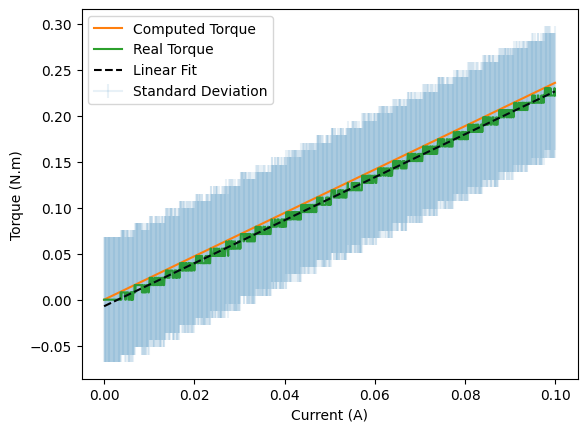

In [6]:
slope, intersect = np.polyfit(currents, real_torque, 1)
poly1d_fn = np.poly1d((slope, intersect))

std_deviation = np.std(real_torque)

print(f"Standard deviation: {std_deviation}")

plt.figure()
plt.errorbar(currents, real_torque, yerr=std_deviation, alpha=0.1, label='Standard Deviation')

plt.plot(currents, computed_torque, label="Computed Torque")
plt.plot(currents, real_torque, label="Real Torque")
plt.plot(currents, poly1d_fn(currents), '--k', label="Linear Fit")

plt.xlabel("Current (A)")
plt.ylabel("Torque (N.m)")
plt.legend()

# Save the plot as an SVG file
plt.savefig("torque_plot.svg", format='svg')

plt.show()

As illustrated by the measures, the servomotor seems to deliver just enough current to reach the desired torque. The "stairs" shape that can be observed can be explained by the 3.36mA step imposed by the servomotor to control it via current control. 

In [7]:
n = len(computed_torque)
sum_base = abs(computed_torque - real_torque).sum()
sum_square = ((computed_torque - real_torque) *(computed_torque - real_torque)).sum()

print(f'Mean Absolute Error : {sum_base/n}')
print(f'Mean Squared Error : {sum_square/n}')
print(f'Root Mean Squared Error : {np.sqrt(sum_square/n)}')

Mean Absolute Error : 0.008197592736867942
Mean Squared Error : 8.953060363187186e-05
Root Mean Squared Error : 0.009462061278171468
